1. Importaciones

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import json
import warnings
import re
from datetime import datetime
warnings.filterwarnings('ignore')


#### 1.0 Funciones útiles

In [2]:
def showPie(columna):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > 15:
    count_values = count_values.iloc[0:15]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15, pref="", title=""):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  count_values.index = count_values.index.astype('str') + pref
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})
  fig = px.pie(datos, values='ocurrencia', names='valor', title=title)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()
  
def nulos_filas(data):
    return pd.DataFrame(data.isna().sum(axis=1).value_counts().reset_index().values, columns=['cant_col_nulas', 'cantidad'])

from IPython.display import display, Markdown

def resumen(data, nombre_tabla="Resumen Tabla"):
    filas, columnas = data.shape
    valores = filas * columnas
    nulos, duplicados =  data.isna().values.sum(), data.duplicated().sum()
    tasa_nulos, tasa_duplicados = nulos / valores, duplicados / valores

    salida = f'''<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>{nombre_tabla}</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> {filas} </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> {columnas} </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> {valores} </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> {nulos} </td><td style='text-align: right'> {round(100*tasa_nulos, 2)} % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> {duplicados} </td><td style='text-align: right'> {round(100*tasa_duplicados, 2)} %</td><tr/>
    </tbody>
    </table>'''

    display(Markdown(salida))

def ver_nulos_x_fila(data):
  ax = sns.barplot(x=nulos_filas(data).cant_col_nulas, y=nulos_filas(data).cantidad)
  for i in ax.containers:
      ax.bar_label(i,)
  plt.title("cantidad nulos x fila")
  plt.show()

def ver_nulos_x_columna(data):
  nulos_columnas = data.isna().sum()[data.isna().sum() > 0].sort_values(ascending=False)
  # ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
  if len(nulos_columnas) > 0:
    ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
    for i in ax.containers:
      ax.bar_label(i,)

## 1.1 Extracción, Transformación y Carga de Datos (ETL)

### 1.1.1 Extracción

In [144]:

# Datos Homicidios Hechos
data_hm = pd.read_excel('data/homicidios.xlsx', sheet_name='HECHOS')

# Datos Homicidios Victimas
data_vm = pd.read_excel('data/homicidios.xlsx', sheet_name='VICTIMAS')
# Datos Lesiones Hechos
# data_hl = pd.read_excel('data/lesiones.xlsx', sheet_name='HECHOS')
data_hl = pd.read_csv('data/generated/data_hl.csv')
# Datos Lesiones Victimas
# data_vl = pd.read_excel('data/lesiones.xlsx', sheet_name='VICTIMAS')
data_vl = pd.read_csv('data/generated/data_vl.csv')

# https://www.indec.gob.ar/ftp/cuadros/poblacion/cnphv2022_resultados_provisionales.pdf Página 8
data_pob_comunas = pd.read_excel('data/cnphv2022_resultados_provisionales.xlsx', sheet_name='Table 2').query("Comuna != 'Total'").iloc[:,[3]]

# Barrios
df_barrios = pd.read_excel('data/barrios.xlsx')
# Comunas
df_comunas = pd.read_excel('data/comunas.xlsx')

In [4]:
# data_hl.to_csv('data/generated/data_hl.csv')
# data_vl.to_csv('data/generated/data_vl.csv')

### 1.1.2 Transformación

### 1.1.2.1 Dataset Homicidios

#### 1.1.2.1.0 Primer Vistazo al Set de Datos

In [5]:
resumen(data_hm)

<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>Resumen Tabla</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> 696 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> 21 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> 14616 </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> 747 </td><td style='text-align: right'> 5.11 % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> 0 </td><td style='text-align: right'> 0.0 %</td><tr/>
    </tbody>
    </table>

#### 1.1.2.1.1 Análisis de Nulos

##### a. Por filas

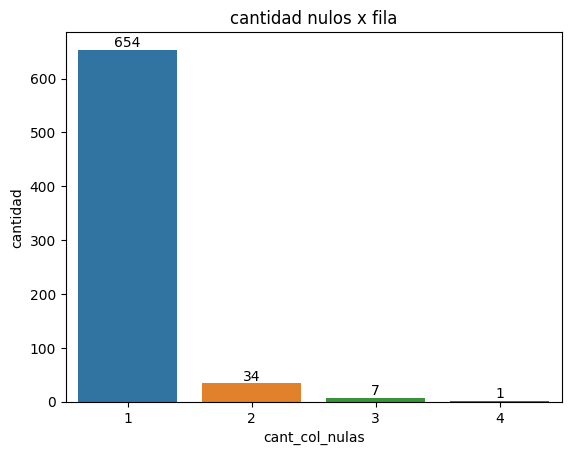

In [6]:
ver_nulos_x_fila(data_hm)

Significa que hay 654 filas que tienen una columna nula, 34 filas con 2 columnas nulas. Este análisis sirve para detectar filas completamente nulas, por ejemplo.

Ahora analizamos los valores nulos por columna.

##### b. Por columnas

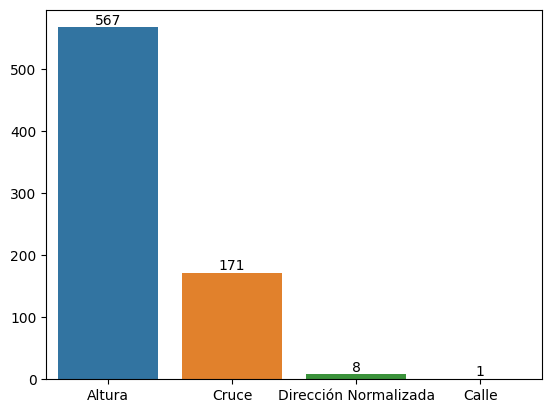

In [7]:
ver_nulos_x_columna(data_hm)

In [8]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo

print(f"Cantidad filas: {data_hm.shape[0]}")
print(f"Cantidad filas al menos un nulo: {len(data_hm.isna().T.sum()>0)}")

Cantidad filas: 696
Cantidad filas al menos un nulo: 696


Vemos que todas las filas tienen al menos un valor nulo.

##### c. Nulos Reales y Estructurales

Después de hacer un oversight sobre el dataset, vemos que Altura y Cruce son excluyentes, cuando está definida la altura es porque es sobre una calle propia y en caso contrario es una esquina. Por lo tanto, vamos a excluirlas del análisis de nulos.

In [9]:
# La columna altura se llena con ESQ cuando es esquina
data_hm.Altura = data_hm.Altura.fillna('ESQ')

# Se limpia el valor altura cuando lo toma como decimal
data_hm.Altura = data_hm.Altura.apply(lambda x: str(x)[:-2] if str(x)[-2:] == '.0' else str(x))

In [10]:
# La columna Cruce se llena con 'NA': 'No Aplica'
data_hm.Cruce = data_hm.Cruce.fillna('NA')

Ya limpio de los nulos estructurales o sea, definidos por la naturaleza de los campos, vamos a los nulos reales.

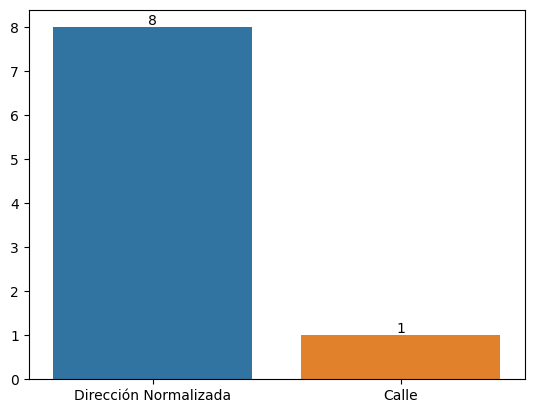

In [11]:
ver_nulos_x_columna(data_hm)

Columna ```Dirección Normalizada```

In [12]:
data_hm[data_hm.isna().loc[:, 'Dirección Normalizada']].head(3)

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
38,2016-0052,1,2016-04-20,2016,4,20,20:00:00,20,AUTOPISTA LUGONES PK 10000,AUTOPISTA,...,ESQ,NA,NaN,13,Point (. .),.,.,MOTO-SD,MOTO,SD
106,2016-0136,1,2016-10-25,2016,10,25,00:00:00,0,AU BUENOS AIRES - LA PLATA KM. 4,AUTOPISTA,...,ESQ,NA,NaN,4,Point (. .),.,.,MOTO-CARGAS,MOTO,CARGAS
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,ESQ,NA,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


Columna ```Calle```

In [13]:
data_hm[data_hm.isna().loc[:, 'Calle']]

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Altura,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO
119,2016-0151,1,2016-11-18,2016,11,18,20:35:00,20,SD,CALLE,...,ESQ,NA,NaN,0,Point (. .),.,.,PEATON-SD,PEATON,SD


Al no tener información suficiente podemos excluir el registro ```2016-0151```. Falleció un peatón, sé a qué fecha-hora, pero no sé en dónde, ni cómo.

In [14]:
data_hm = data_hm.drop(data_hm[data_hm['ID']=='2016-0151'].index)

Columna <code>Dirección Normalizada</code>

Rellenamos la información faltante en la columna ```Dirección Normalizada``` con los valores de ```LUGAR_DEL_HECHO```

In [15]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]
for i in nulos:
    data_hm['Dirección Normalizada'].iloc[i] = data_hm['LUGAR_DEL_HECHO'].iloc[i]

Según lo visto, cuando la dirección normalizada es nula es porque ocurre en autopista, sólo un caso en el que es calle porque es un registro con valores nulos o sin datos, del que se puede prescindir.

Vemos que hay otros valores nulos encubiertos, como ```'.'``` en las coordenadas GPS, o ```Point (. .)```, en las otras coordenads espaciales, o ```SD``` en otros campos. Inclusive ```0``` en la columna ```COMUNA```, siendo 15 comunas a partir de la 1.

Columnas <code>"pos x"</code> y <code>"pos y"</code>

Marcamos las filas que no tienen valores geográficos.

In [16]:
data_hm['geo_info'] = True

limpiar_coord = lambda x: 0 if x == '.' else float(x)
data_hm['pos x'] = data_hm['pos x'].apply(limpiar_coord)
data_hm['pos y'] = data_hm['pos y'].apply(limpiar_coord)

for i in data_hm.index:
    if data_hm.loc[i, 'pos x'] == 0:
        data_hm.loc[i, 'geo_info'] = False
    if data_hm.loc[i, 'pos y'] == 0:
        data_hm.loc[i, 'geo_info'] = False

data_hm['geo_info'].value_counts()        

geo_info
True     684
False     11
Name: count, dtype: int64

Columna <code>COMUNA</code>

In [17]:
data_hm.COMUNA = data_hm.COMUNA.astype(str)

In [18]:
data_hm.query("COMUNA == '0'")

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info
139,2016-0174,1,2016-12-27,2016,12,27,00:00:00,0,AUTOPISTA 25 DE MAYO,AUTOPISTA,...,NA,AUTOPISTA 25 DE MAYO,0,Point (. .),0.0,0.0,SD-SD,SD,SD,False


Eliminada por falta de datos

In [19]:
data_hm.drop(139, axis =0, inplace = True)

In [20]:
data_hm.COMUNA.isna().sum()

0

Podemos prescindir de las columnas ```AAAA, MM, DD, HH, XY (CABA)``` ya que duplican información

In [21]:
data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

Columna <code>Hora</code>

In [22]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info
518,2019-0103,1,2019-12-18,SD,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,"PAZ, GRAL. AV.",ESQ,GRIVEO,"PAZ, GRAL. AV. y GRIVEO",11,-58.521694,-34.594716,MOTO-MOTO,MOTO,MOTO,True


In [23]:
data_hm["HORA"] = data_hm["HORA"].replace('SD', '00:00:00')
data_hm["HORA"] = data_hm["HORA"].astype(str)
data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)
data_hm['HORA'] = data_hm['HORA'].astype(str)

Creación de la columna <code>FECHA_HORA</code> a partir de las columnas de fecha y hora.

In [24]:
import re

pattern = r'[:\s;-]'

data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: re.split(pattern, x))
data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(lambda x: list(map(int, x)))

def to_date(t):
    return datetime(* t)

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(to_date)



In [25]:
# data_hm['FECHA_HORA']

In [26]:
# for i in data_hm['FECHA_HORA']:
#     list(map(int, i))

# data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(lambda x: list(map(int, x)))

In [27]:

# # data_hm['FECHA_HORA'].apply(lambda t: datetime(*map(int,t)))

# for i, f in enumerate(data_hm['FECHA_HORA']):
#     for n in f:
#         n = int(n)
#     data_hm['FECHA_HORA'].loc[i] = f



In [28]:
data_hm['FECHA_HORA'] 

0     2016-01-01 04:00:00
1     2016-01-02 01:15:00
2     2016-01-03 07:00:00
3     2016-01-10 00:00:00
4     2016-01-21 05:20:00
              ...        
691   2021-12-13 17:10:00
692   2021-12-20 01:10:00
693   2021-12-30 00:43:00
694   2021-12-15 10:30:00
695   2021-11-18 06:10:00
Name: FECHA_HORA, Length: 694, dtype: datetime64[ns]

In [29]:
type(data_hm['PARTICIPANTES'][0])

str

In [30]:
# import json
coordinates = [data_hm['pos x'].sample(1).values[0], data_hm['pos y'].sample(2).values[0]]

# Create a GeoJSON point feature
point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)}
} for x, y, p, d in zip(data_hm['pos x'].values, data_hm['pos y'].values, data_hm['PARTICIPANTES'].values, data_hm['Dirección Normalizada'].values)]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

# pd.DataFrame(point_geojson)

json_file_path = "data/generated/output.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

In [31]:
data_hm[data_hm['geo_info']]['pos x'].mean()

-58.441545233561044

In [32]:
data_hm[data_hm['geo_info']]['pos y'].mean()

-34.61963157034327

In [33]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]



In [34]:
# data_.iloc[data_['Dirección Normalizada'].isna(), 13] = data_.iloc[data_['Dirección Normalizada'].isna(), 8].values

In [35]:

data = data_hm.set_index(data_hm.ID)
data.drop('ID', axis=1, inplace=True,errors='ignore')
data

,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info,FECHA_HORA
ID,,,,,,,,,,,,,,,,,
2016-0001,1,2016-01-01,04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00
2016-0002,1,2016-01-02,01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00
2016-0003,1,2016-01-03,07:00:00,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00
2016-0004,1,2016-01-10,00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00
2016-0005,1,2016-01-21,05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,2021-12-13,17:10:00,AV. RIESTRA Y MOM,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00
2021-0094,1,2021-12-20,01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00
2021-0095,1,2021-12-30,00:43:00,AV. GAONA Y TERRADA,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00


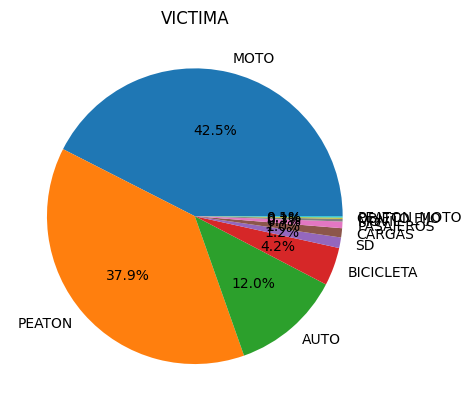

In [36]:
showPie(data['VICTIMA'])

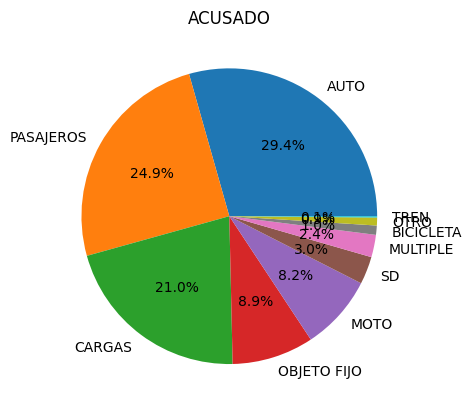

In [37]:
showPie(data['ACUSADO'])

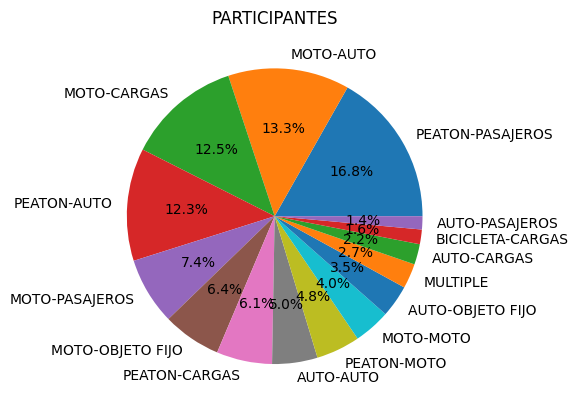

In [38]:
showPie(data['PARTICIPANTES'])

In [39]:
data.describe()

,N_VICTIMAS,FECHA,pos x,pos y,FECHA_HORA
count,694.000000,694,694.000000,694.000000,694
mean,1.030259,2018-09-16 01:52:02.766570496,-57.599448,-34.120790,2018-09-16 13:52:40.442363136
min,1.000000,2016-01-01 00:00:00,-58.529942,-34.705250,2016-01-01 04:00:00
25%,1.000000,2017-04-04 18:00:00,-58.475701,-34.643537,2017-04-05 13:41:15
50%,1.000000,2018-07-14 12:00:00,-58.443654,-34.622535,2018-07-14 18:47:00
75%,1.000000,2020-01-04 18:00:00,-58.399650,-34.595143,2020-01-05 11:40:00
max,3.000000,2021-12-30 00:00:00,0.000000,0.000000,2021-12-30 00:43:00
std,0.179644,NaN,6.969679,4.128761,NaN


In [40]:
# data['ACUSADO'].corr(data['VICTIMA'])

In [41]:


df_comunas['barrios'] = df_comunas.BARRIOS.apply(lambda x: x.split(' - '))

# pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas[['ID', 'COMUNAS']], left_on='comuna_id', right_on='ID')
df_comunas.set_index('COMUNAS', drop=True, inplace=True)
df_comunas.drop('ID', axis = 1, inplace=True, errors='ignore')
df_comunas.sort_index()

,OBJETO,BARRIOS,PERIMETRO,AREA,barrios
COMUNAS,,,,,
1,LIMITE COMUNAL,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,"[CONSTITUCION, MONTSERRAT, PUERTO MADERO, RETI..."
2,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
3,LIMITE COMUNAL,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,"[BALVANERA, SAN CRISTOBAL]"
4,LIMITE COMUNAL,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,35423.282799,2.168464e+07,"[BARRACAS, BOCA, NUEVA POMPEYA, PARQUE PATRICIOS]"
5,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
6,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
7,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
8,LIMITE COMUNAL,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,20935.012513,2.221690e+07,"[VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI]"
9,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"


In [42]:
pd.merge(pd.DataFrame(df_comunas.barrios.explode()).reset_index(names='comuna_id'), df_comunas, left_on='comuna_id', right_on='COMUNAS')

,comuna_id,barrios_x,OBJETO,BARRIOS,PERIMETRO,AREA,barrios_y
0,2,RECOLETA,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
1,5,ALMAGRO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
2,5,BOEDO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
3,6,CABALLITO,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
4,7,FLORES,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
5,7,PARQUE CHACABUCO,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
6,9,LINIERS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
7,9,MATADEROS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
8,9,PARQUE AVELLANEDA,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
9,10,FLORESTA,LIMITE COMUNAL,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"[FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS..."


In [43]:
barrio_comuna = pd.DataFrame(df_comunas.barrios.explode())

In [44]:
barrio_comuna

,barrios
COMUNAS,
2,RECOLETA
5,ALMAGRO
5,BOEDO
6,CABALLITO
7,FLORES
7,PARQUE CHACABUCO
9,LINIERS
9,MATADEROS
9,PARQUE AVELLANEDA


In [45]:
# barrios.BARRIO.

In [46]:
# import pandas as pd
# import researchpy as rp

# # Assuming df is your DataFrame containing the categorical variables
# # Let's say 'var1' and 'var2' are the columns representing the categorical variables

# data = data.reset_index()

# # Create a contingency table (cross-tabulation)
# contingency_table = pd.crosstab(data['ACUSADO'], data['VICTIMA'])

# # Calculate Cramér's V
# cramers_v_result = rp.crosstab(data['ACUSADO'], data['VICTIMA'], 
#                                 prop= 'cell', 
#                                 test= 'chi-square', 
#                                 expected_freqs= True, 
                                
#                                 correction= False)['results']

# cramers_v = cramers_v_result.loc[2, 'results']

# print("Cramér's V:", cramers_v)


In [47]:
# %pip install ipywidgets

In [48]:
pd.crosstab(data_hm['VICTIMA'], data_hm['ACUSADO'])


ACUSADO,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
VICTIMA,,,,,,,,,,
AUTO,31,0,14,0,3,21,1,9,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,83,2,78,25,8,40,4,46,9,0
MOVIL,0,0,1,0,0,0,0,1,0,0
OBJETO FIJO,1,0,0,0,0,0,0,0,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,77,5,38,30,5,0,0,105,3,0
PEATON_MOTO,0,0,0,1,0,0,0,0,0,0


In [49]:
data_hm['ES_CRUCE'] = data_hm['Cruce'] != 'NA'

In [50]:
data_hm['ES_CRUCE'].value_counts()

ES_CRUCE
True     525
False    169
Name: count, dtype: int64

In [51]:
data_hm['Cruce'].fillna('NA', inplace=True)

In [52]:
pd.crosstab(data_hm['PARTICIPANTES'], data_hm['ES_CRUCE']).sum()

ES_CRUCE
False    169
True     525
dtype: int64

In [53]:
data_hm = data_hm.set_index(data_hm['ID']).drop(['ID','FECHA','HORA','LUGAR_DEL_HECHO'], axis=1)

In [54]:
data_hm.columns = [c.lower().replace(' ','_') for c in data_hm.columns]

# plt.plot(data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum())

In [55]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


In [56]:
data_hm['comuna'][data_hm['comuna'].isnull()]

Series([], Name: comuna, dtype: object)

In [57]:
data_hm['comuna'] = data_hm['comuna'].apply(lambda x: int(x))

In [58]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


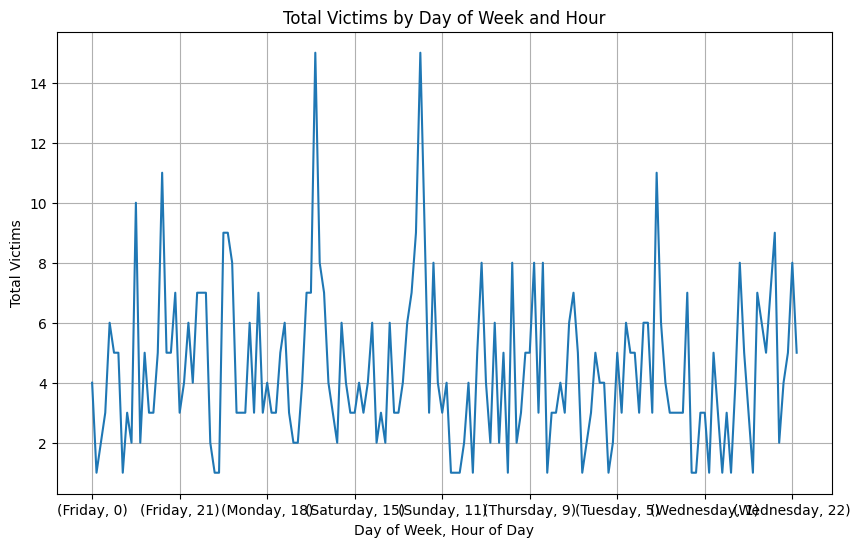

In [59]:
import matplotlib.pyplot as plt

# Assuming data_hm['fecha_hora'] is already a datetime column in data_hm

# Group by day name and hour, then sum 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum()

# Plot the result
grouped_data.plot(kind='line', figsize=(10, 6))
plt.xlabel('Day of Week, Hour of Day')
plt.ylabel('Total Victims')
plt.title('Total Victims by Day of Week and Hour')
plt.grid(True)
plt.show()


In [60]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Hour_of_Day', y='n_victimas', color='Day_of_Week', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [61]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Day_of_Week', y='n_victimas', color='Hour_of_Day', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Day_of_Week': 'Day of Week', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [62]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Iterate over unique days and create a separate bar plot for each day
for day in grouped_data['Day_of_Week'].unique():
    # Filter data for the current day
    day_data = grouped_data[grouped_data['Day_of_Week'] == day]
    
    # Create a bar plot for the current day
    fig = px.bar(day_data, x='Hour_of_Day', y='n_victimas', 
                 title=f'Total Number of Victims by Hour on {day}',
                 labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'})
    
    # Show the plot
    fig.show()


In [63]:
data_hm['es_cruce'] = data_hm['es_cruce'].map({False:'Calle', True:'Esquina'})

In [64]:
import plotly.express as px

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a pie chart using Plotly Express
fig = px.pie(grouped_data, values='n_victimas', names='es_cruce', 
             title='Proportion of Victims by Crossing Status')

# Show the plot
fig.show()

In [65]:
data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()['es_cruce'].map({False:"Calle", True:"Esquina"})

0    NaN
1    NaN
Name: es_cruce, dtype: object

In [66]:
import pandas as pd

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a mapping dictionary
mapping = {False: "Calle", True: "Esquina"}

# Map boolean values to corresponding labels
grouped_data['es_cruce'] = grouped_data['es_cruce'].map(mapping)

# Show the result
print(grouped_data)

  es_cruce  n_victimas
0      NaN         175
1      NaN         540


In [67]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                 data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Año', y='n_victimas', color='Mes',
             title='Total Number of Victims by Day of Year and Month',)
            #  labels={'Año': 'Day of Week', 'n_victimas': 'Total Victims'},
            #  category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()

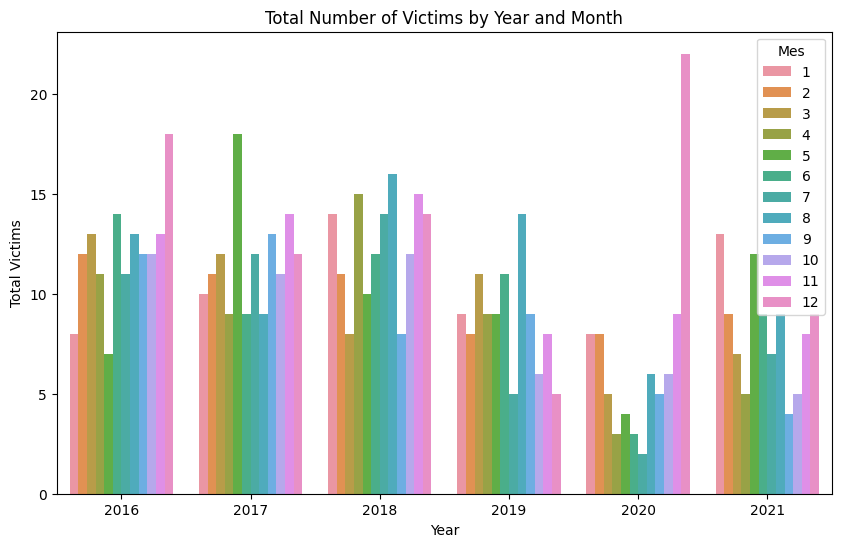

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by year and month, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='Año', y='n_victimas', hue='Mes')

# Set plot title and labels
plt.title('Total Number of Victims by Year and Month')
plt.xlabel('Year')
plt.ylabel('Total Victims')

# Show the plot
plt.show()


In [69]:
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

grouped_data

,Año,Mes,n_victimas
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [70]:
data_hm.groupby(data_hm['fecha_hora'].dt.to_period('M'))['n_victimas'].sum()

fecha_hora
2016-01     8
2016-02    12
2016-03    13
2016-04    11
2016-05     7
           ..
2021-08     9
2021-09     4
2021-10     5
2021-11     8
2021-12     9
Freq: M, Name: n_victimas, Length: 72, dtype: int64

In [71]:
data_hm['fecha_hora'].dt.to_period('M')

ID
2016-0001    2016-01
2016-0002    2016-01
2016-0003    2016-01
2016-0004    2016-01
2016-0005    2016-01
              ...   
2021-0093    2021-12
2021-0094    2021-12
2021-0095    2021-12
2021-0096    2021-12
2021-0097    2021-11
Name: fecha_hora, Length: 694, dtype: period[M]

In [72]:
import plotly.express as px

# Group data by month, summing 'n_victimas'
grouped_data = data_hm.groupby(data_hm['fecha_hora'].dt.to_period('Y'))['n_victimas'].sum().reset_index()

# Convert Period objects to strings
grouped_data['fecha_hora'] = grouped_data['fecha_hora'].astype(str)

# Create a line plot using Plotly Express
fig = px.line(grouped_data, x='fecha_hora', y='n_victimas', 
              title='Total Number of Victims Over Time',
              labels={'fecha_hora': 'Month', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()


In [73]:
# data_hm.to_excel('data/generated/data_hm.xlsx')

In [74]:
data_hm.pos_y.mean()

-34.12078961688012

In [75]:
import folium
from branca.colormap import LinearColormap

# Assuming data contains latitude, longitude, and the value you want to use for color
# Replace 'value_column' with the actual name of the column in your DataFrame
value_column = 'comuna'

data_hm[value_column] = pd.to_numeric(data_hm[value_column], errors='coerce')

data_hm = data_hm.dropna()
data_hm = data_hm.rename({'pos_x': 'lon',  'pos_y': 'lat'}, axis=1)

# Define the minimum and maximum values for the color scale
min_value = data_hm[value_column].astype(float).min()
max_value = data_hm[value_column].astype(float).max()

# Create a color gradient
colormap = LinearColormap(['blue', 'yellow', 'red'], vmin=min_value, vmax=max_value)

# Create a Folium Map
map = folium.Map()

# Iterate over DataFrame rows
for i, row in data_hm.iterrows():
    # Get latitude, longitude, and value
    lat = row['lat']
    lon = row['lon']
    value = row[value_column]
    
    # Get marker color based on the value
    color = colormap(value)
    
    # Create marker with the specified color
    folium.Marker(location=(lat, lon), icon=folium.Icon(color=color)).add_to(map)

# Display the map
# map

In [76]:
import csv

data_hm.to_csv('data/generated/data_hm.csv', sep=';', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8')

In [77]:
data = pd.read_csv('data/generated/data_hm.csv', sep=';', encoding='utf-8')

In [78]:
data.iloc[136]

ID                                         2016-0172
n_victimas                                         1
tipo_de_calle                                AVENIDA
calle                             GARAY, JUAN DE AV.
altura                                           ESQ
cruce                                         CASTRO
dirección_normalizada    GARAY, JUAN DE AV. y CASTRO
comuna                                             5
lon                                       -58.419189
lat                                       -34.631743
participantes                            MOTO-CARGAS
victima                                         MOTO
acusado                                       CARGAS
geo_info                                        True
fecha_hora                       2016-12-26 08:00:00
es_cruce                                     Esquina
Name: 136, dtype: object

In [79]:
# data_hm.to_excel('data/generated/data_hm.xlsx', engine='openpyxl')

In [80]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 2016-0001 to 2021-0097
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   n_victimas             694 non-null    int64         
 1   tipo_de_calle          694 non-null    object        
 2   calle                  694 non-null    object        
 3   altura                 694 non-null    object        
 4   cruce                  694 non-null    object        
 5   dirección_normalizada  694 non-null    object        
 6   comuna                 694 non-null    int64         
 7   lon                    694 non-null    float64       
 8   lat                    694 non-null    float64       
 9   participantes          694 non-null    object        
 10  victima                694 non-null    object        
 11  acusado                694 non-null    object        
 12  geo_info               694 non-null    bool          
 

In [81]:
data_dias = data_hm.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias})

In [82]:
data_dias = data.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

In [83]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

,fecha_hora,n_victimas
0,0,103
1,1,96
2,2,97
3,3,94
4,4,95
5,5,102
6,6,97


In [84]:
data_dias = data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias},
             orientation='h')

fig.show()

In [85]:
data.query('fecha_hora.dt.month == 12 and fecha_hora.dt.year == 2020').n_victimas.sum()

22

In [86]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

datos = data.groupby([data['fecha_hora'].dt.year, data['fecha_hora'].dt.month//6 + 1, data['fecha_hora'].dt.month])['n_victimas'].sum()

datos = datos.rename_axis(['Year', 'Semester', 'Month'])

datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Month' as a string
datos['date'] = datos['Year'].astype(str) + '-' + datos['Month'].astype(str).str.zfill(2)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Month and Year',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'},
             color='n_victimas')

# Show the plot
fig.show()

# datos.head(50)

In [87]:
datos = data.groupby([data['fecha_hora'].dt.year, (data['fecha_hora'].dt.month - 1) // 6 + 1])['n_victimas'].sum()

# Rename the MultiIndex
datos = datos.rename_axis(['Year', 'Semester'])

# Reset the index
datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Semester' as a string
datos['date'] = datos['Year'].astype(str) + '-Semester ' + datos['Semester'].astype(str)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Year and Semester',
             color='n_victimas',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()

In [88]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,lon,lat,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,Esquina
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,Esquina
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,Calle
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,Esquina
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,Esquina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,Esquina
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,Esquina
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,Esquina


### 1.1.2.2 Dataset Lesiones

#### 1.1.2.1.0 Primer Vistazo al Set de Datos

In [177]:
columnas_usar = ['id', 'n_victimas', 'fecha', 'hora',
       'direccion_normalizada', 'comuna', 'tipo_calle',
       'otra_direccion', 'calle', 'altura', 'cruce', 
       'longitud', 'latutid', 'victima', 'acusado', 'participantes', 'moto',
       'auto', 'transporte_publico', 'camion', 'ciclista', 'gravedad']

data_hl = pd.read_csv('data/generated/data_hl.csv', usecols=columnas_usar)

In [178]:
data_hl

,id,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,otra_direccion,calle,altura,...,latutid,victima,acusado,participantes,moto,auto,transporte_publico,camion,ciclista,gravedad
0,LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,SD,14,SD,"Obligado Rafael, Av.Costanera 3300, Barrio: Pa...",NaN,NaN,...,-34.559658,CICLISTA,SD,CICLISTA-SD,SD,SD,SD,SD,x,SD
1,LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,SD,8,SD,"Autopista Presidente Héctor J. Cámpora y Roca,...",NaN,NaN,...,-34.669125,AUTO,SD,AUTO-SD,SD,x,SD,SD,SD,SD
2,LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,SD,8,SD,"Barros Pazos, Jose y Larraya 0, Barrio: Villa ...",NaN,NaN,...,-34.677556,SD,SD,SD-SD,SD,SD,SD,SD,SD,SD
3,LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,SD,7,SD,"Torres Y Tenorio, Pres. y Riestra Av. 0, Barri...",NaN,NaN,...,-34.647349,PEATON,SD,PEATON-SD,x,SD,SD,SD,SD,SD
4,LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,SD,3,SD,"Corrientes Av. y Uriburu Jose E., Pres. 0, Bar...",NaN,NaN,...,-34.604579,AUTO,SD,AUTO-SD,SD,SD,x,SD,SD,SD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23780,LC-2021-0652849,1,2021-12-31 00:00:00,19:30:00,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,AVENIDA,SD,"ALBERDI, JUAN BAUTISTA AV.",0.0,...,-34.659713573880,SD,SD,SD-SD,SD,SD,SD,SD,SD,SD
23781,LC-2021-0652865,2,2021-12-31 00:00:00,19:40:00,"ALBERDI, JUAN BAUTISTA AV. 4436",9,AVENIDA,SD,"ALBERDI, JUAN BAUTISTA AV.",4436.0,...,-34.641753304864,SD,SD,SD-SD,SD,SD,SD,SD,SD,SD
23782,LC-2021-0652907,1,2021-12-31 00:00:00,20:00:00,SD,1,SD,Barrio Padre Carlos Mugica (Villa 31 bis),NaN,NaN,...,-34.583083,SD,SD,SD-SD,SD,SD,SD,SD,SD,SD
23783,LC-2021-0652921,1,2021-12-31 00:00:00,22:00:00,LINIERS VIRREY y MORENO,5,CALLE,SD,LINIERS VIRREY,0.0,...,-34.614288229345,MOTO,TRANSPORTE PUBLICO,MOTO-TRANSPORTE PUBLICO,x,0,x,0,0,GRAVE


In [179]:
data_hl.replace('SD', np.nan, inplace=True)
resumen(data_hl, "Lesiones")

<table>
    <thead>
    <tr><th colspan=3 style='text-align: center'>Lesiones</th></tr>
    </thead>
    <tbody>
    <tr><th> Detalle </th><th> Cantidad </th><th>Tasa</th></tr>
    <tr><td> Filas </td><td style='text-align: right'> 23785 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Columnas </td><td style='text-align: right'> 22 </td><td style='text-align: center'>---</td><tr/>
    <tr><td> Valores </td><td style='text-align: right'> 523270 </td><td style='text-align: center'>---</td<tr/>
    <tr><td> Nulos </td><td style='text-align: right'> 186937 </td><td style='text-align: right'> 35.72 % </td><tr/>
    <tr><td> Duplicados </td><td style='text-align: right'> 0 </td><td style='text-align: right'> 0.0 %</td><tr/>
    </tbody>
    </table>

#### 1.1.2.2.1 Análisis de Nulos

##### a. Por filas

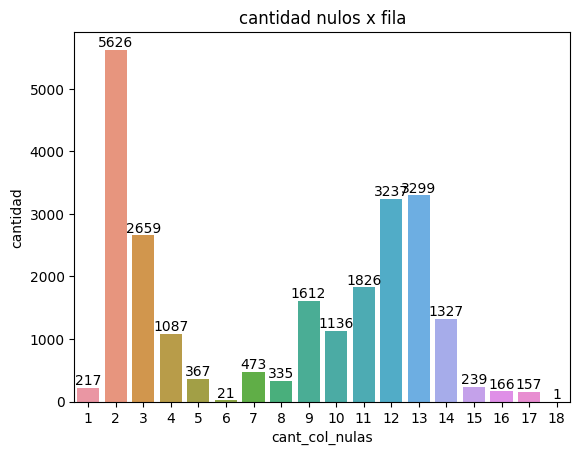

In [180]:
ver_nulos_x_fila(data_hl)

Significa que hay 287 filas que tienen una columna nula, 7437 filas con 2 columnas nula. Este análisis sirve para detectar filas completamente nulas, por ejemplo.

Ahora analizamos los valores nulos por columna.

##### b. Por columnas

Separamos un subset para trabajar después

In [181]:
data_adicional = data_hl[['id','moto', 'auto', 'transporte_publico', 'camion', 'ciclista']]

data_adicional['involucrado'] = data_adicional.eq('x').idxmax(axis=1).str.upper()
data_adicional['involucrado'] = data_adicional['involucrado'].apply(lambda x: 'SD' if x == 'ID' else x)

In [183]:
data_hl = data_hl[data_hl.columns[~data_hl.columns.isin(data_adicional.columns)]]
# data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

In [184]:
data_hl

,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,otra_direccion,calle,altura,cruce,longitud,latutid,victima,acusado,participantes,gravedad
0,1,2019-01-01 00:00:00,09:00:00,NaN,14,NaN,"Obligado Rafael, Av.Costanera 3300, Barrio: Pa...",NaN,NaN,NaN,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA-SD,NaN
1,1,2019-01-01 00:00:00,01:55:00,NaN,8,NaN,"Autopista Presidente Héctor J. Cámpora y Roca,...",NaN,NaN,NaN,-58.44351,-34.669125,AUTO,NaN,AUTO-SD,NaN
2,1,2019-01-01 00:00:00,02:00:00,NaN,8,NaN,"Barros Pazos, Jose y Larraya 0, Barrio: Villa ...",NaN,NaN,NaN,-58.468335,-34.677556,NaN,NaN,SD-SD,NaN
3,1,2019-01-01 00:00:00,02:30:00,NaN,7,NaN,"Torres Y Tenorio, Pres. y Riestra Av. 0, Barri...",NaN,NaN,NaN,-58.437425,-34.647349,PEATON,NaN,PEATON-SD,NaN
4,4,2019-01-01 00:00:00,04:30:00,NaN,3,NaN,"Corrientes Av. y Uriburu Jose E., Pres. 0, Bar...",NaN,NaN,NaN,-58.398225,-34.604579,AUTO,NaN,AUTO-SD,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23780,1,2021-12-31 00:00:00,19:30:00,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,AVENIDA,NaN,"ALBERDI, JUAN BAUTISTA AV.",0.0,GUAMINI,-58.513477158887,-34.659713573880,NaN,NaN,SD-SD,NaN
23781,2,2021-12-31 00:00:00,19:40:00,"ALBERDI, JUAN BAUTISTA AV. 4436",9,AVENIDA,NaN,"ALBERDI, JUAN BAUTISTA AV.",4436.0,NaN,-58.488326609395,-34.641753304864,NaN,NaN,SD-SD,NaN
23782,1,2021-12-31 00:00:00,20:00:00,NaN,1,NaN,Barrio Padre Carlos Mugica (Villa 31 bis),NaN,NaN,NaN,-58.382894,-34.583083,NaN,NaN,SD-SD,NaN
23783,1,2021-12-31 00:00:00,22:00:00,LINIERS VIRREY y MORENO,5,CALLE,NaN,LINIERS VIRREY,0.0,MORENO,-58.414532050899,-34.614288229345,MOTO,TRANSPORTE PUBLICO,MOTO-TRANSPORTE PUBLICO,GRAVE


Dividimos el dataset en 2 para trabajar mejor con los gráficos

In [185]:
data_1 = data_hl.iloc[:, :int(data_hl.shape[1]/2)]

data_2 = data_hl.iloc[:,int(data_hl.shape[1]/2)+1:]

In [187]:
data_1.columns

Index(['n_victimas', 'fecha', 'hora', 'direccion_normalizada', 'comuna',
       'tipo_calle', 'otra_direccion', 'calle'],
      dtype='object')

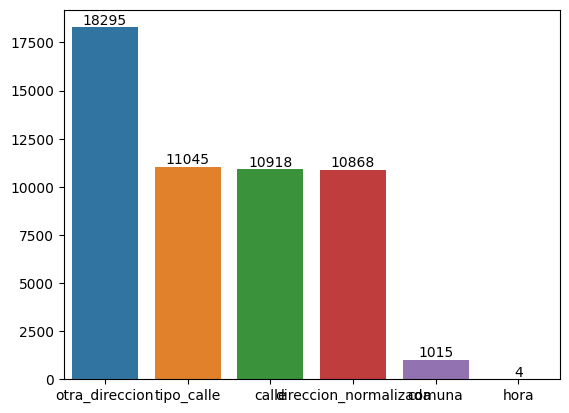

In [188]:
nulos_columnas = data_1.isna().sum()[data_1.isna().sum() > 0].sort_values(ascending=False)
ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

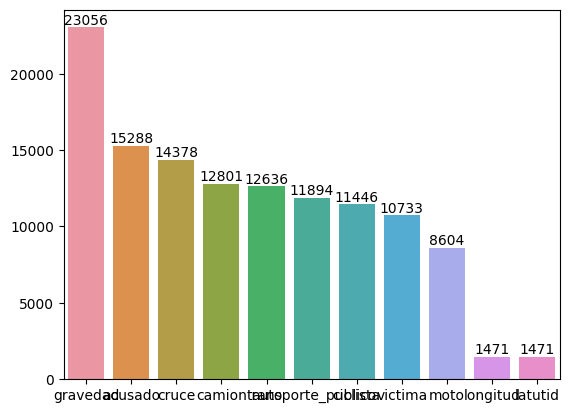

In [119]:
nulos_columnas = data_2.isna().sum()[data_2.isna().sum() > 0].sort_values(ascending=False)
ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [120]:
# la cantidad de filas del data frame es igual a la cantidad de filas que tiene un al menos un valor nulo

print(f"Cantidad filas: {data_hl.shape[0]}")
print(f"Cantidad filas al menos un nulo: {len(data_hl.isna().T.sum()>0)}")

Cantidad filas: 23785
Cantidad filas al menos un nulo: 23785


Debido a la gran cantidad de nulos, y viendo un panorama del dataset, vamos a hacer un recorte de las columnas más útiles a criterio del analista

In [121]:
columnas_conservar = ['id', 'n_victimas', 'fecha', 'hora','direccion_normalizada', 'comuna','tipo_calle','otra_direccion','calle','altura','cruce','longitud', 'latutid', 'victima', 'gravedad']


In [122]:
data_adicional = data_hl[['id','moto', 'auto', 'transporte_publico', 'camion', 'ciclista']]

data_adicional['involucrado'] = data_adicional.eq('x').idxmax(axis=1).str.upper()
data_adicional['involucrado'] = data_adicional['involucrado'].apply(lambda x: 'SD' if x == 'ID' else x)

In [123]:
data_hl = data_hl[columnas_conservar]

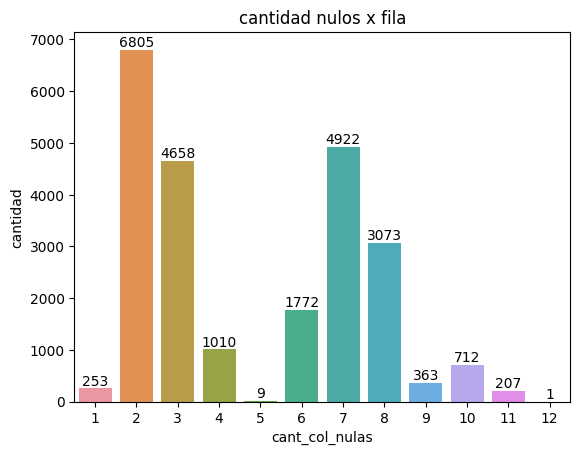

In [124]:
ver_nulos_x_fila(data_hl)

In [125]:


data_hl = pd.merge(data_hl,data_adicional, on='id')

In [126]:
data_hl

,id,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,otra_direccion,calle,altura,...,longitud,latutid,victima,gravedad,moto,auto,transporte_publico,camion,ciclista,involucrado
0,LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,NaN,14,NaN,"Obligado Rafael, Av.Costanera 3300, Barrio: Pa...",NaN,NaN,...,-58.408911,-34.559658,CICLISTA,NaN,NaN,NaN,NaN,NaN,x,CICLISTA
1,LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,NaN,8,NaN,"Autopista Presidente Héctor J. Cámpora y Roca,...",NaN,NaN,...,-58.44351,-34.669125,AUTO,NaN,NaN,x,NaN,NaN,NaN,AUTO
2,LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,NaN,8,NaN,"Barros Pazos, Jose y Larraya 0, Barrio: Villa ...",NaN,NaN,...,-58.468335,-34.677556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SD
3,LC-2019-0000079,1,2019-01-01 00:00:00,02:30:00,NaN,7,NaN,"Torres Y Tenorio, Pres. y Riestra Av. 0, Barri...",NaN,NaN,...,-58.437425,-34.647349,PEATON,NaN,x,NaN,NaN,NaN,NaN,MOTO
4,LC-2019-0000082,4,2019-01-01 00:00:00,04:30:00,NaN,3,NaN,"Corrientes Av. y Uriburu Jose E., Pres. 0, Bar...",NaN,NaN,...,-58.398225,-34.604579,AUTO,NaN,NaN,NaN,x,NaN,NaN,TRANSPORTE_PUBLICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23780,LC-2021-0652849,1,2021-12-31 00:00:00,19:30:00,"ALBERDI, JUAN BAUTISTA AV. y GUAMINI",9,AVENIDA,NaN,"ALBERDI, JUAN BAUTISTA AV.",0.0,...,-58.513477158887,-34.659713573880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SD
23781,LC-2021-0652865,2,2021-12-31 00:00:00,19:40:00,"ALBERDI, JUAN BAUTISTA AV. 4436",9,AVENIDA,NaN,"ALBERDI, JUAN BAUTISTA AV.",4436.0,...,-58.488326609395,-34.641753304864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SD
23782,LC-2021-0652907,1,2021-12-31 00:00:00,20:00:00,NaN,1,NaN,Barrio Padre Carlos Mugica (Villa 31 bis),NaN,NaN,...,-58.382894,-34.583083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SD
23783,LC-2021-0652921,1,2021-12-31 00:00:00,22:00:00,LINIERS VIRREY y MORENO,5,CALLE,NaN,LINIERS VIRREY,0.0,...,-58.414532050899,-34.614288229345,MOTO,GRAVE,x,0,x,0,0,MOTO


In [127]:
data_hl.dropna(subset=['comuna'], inplace=True)

data_hl.drop(['transporte_publico',	'moto',  'auto', 'camion',	'ciclista'], axis=1, inplace=True, errors='ignore')

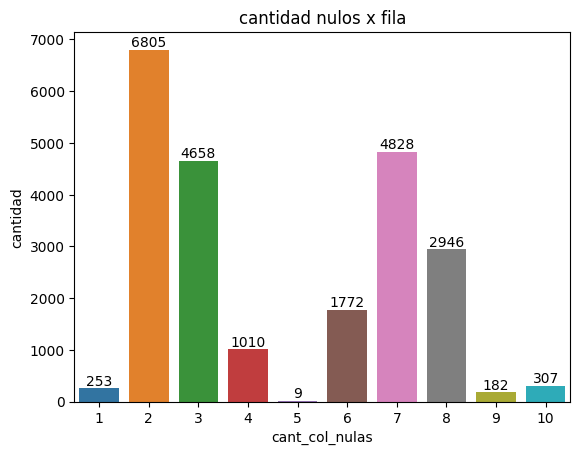

In [128]:
# ax = sns.barplot(x=nulos_filas(data_hl2).cant_col_nulas, y=nulos_filas(data_hl2).cantidad)
# for i in ax.containers:
#     ax.bar_label(i,)
# plt.title("cantidad nulos x fila")
# plt.show()

ver_nulos_x_fila(data_hl)

Vemos que todas las filas tienen al menos un valor nulo.

##### c. Nulos Reales y Estructurales

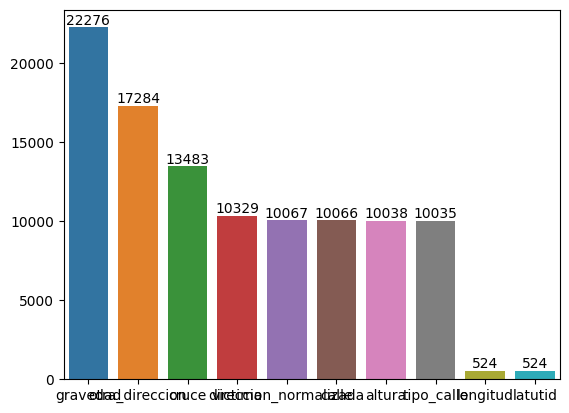

In [129]:
ver_nulos_x_columna(data_hl)

Columna <code>Gravedad</code>

In [130]:
data_hl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22770 entries, 0 to 23783
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     22770 non-null  object 
 1   n_victimas             22770 non-null  int64  
 2   fecha                  22770 non-null  object 
 3   hora                   22770 non-null  object 
 4   direccion_normalizada  12703 non-null  object 
 5   comuna                 22770 non-null  object 
 6   tipo_calle             12735 non-null  object 
 7   otra_direccion         5486 non-null   object 
 8   calle                  12704 non-null  object 
 9   altura                 12732 non-null  float64
 10  cruce                  9287 non-null   object 
 11  longitud               22246 non-null  object 
 12  latutid                22246 non-null  object 
 13  victima                12441 non-null  object 
 14  gravedad               494 non-null    object 
 15  involuc

In [131]:
data_hl.cruce

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
23779        NaN
23780    GUAMINI
23781        NaN
23782        NaN
23783     MORENO
Name: cruce, Length: 22770, dtype: object

In [132]:
# La columna Cruce se llena con 'NA': 'No Aplica'
data_hl.cruce = data_hl.cruce.fillna('NA')

Ya limpio de los nulos estructurales o sea, definidos por la naturaleza de los campos, vamos a los nulos reales.

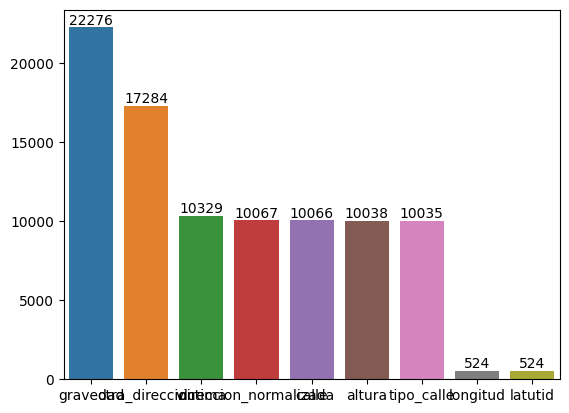

In [133]:
nulos_columnas = data_hl.isna().sum()[data_hl.isna().sum() > 0].sort_values(ascending=False)

if len(nulos_columnas) > 0:
    ax = sns.barplot(x=nulos_columnas.index, y=nulos_columnas.values)
for i in ax.containers:
    ax.bar_label(i,)

In [134]:
data_hl.calle

0                               NaN
1                               NaN
2                               NaN
3                               NaN
4                               NaN
                    ...            
23779                          VIEL
23780    ALBERDI, JUAN BAUTISTA AV.
23781    ALBERDI, JUAN BAUTISTA AV.
23782                           NaN
23783                LINIERS VIRREY
Name: calle, Length: 22770, dtype: object

Columna ```Dirección Normalizada```

In [135]:
data_hl[data_hl.isna().loc[:, 'direccion_normalizada']].head(3)

,id,n_victimas,fecha,hora,direccion_normalizada,comuna,tipo_calle,otra_direccion,calle,altura,cruce,longitud,latutid,victima,gravedad,involucrado
0,LC-2019-0000179,1,2019-01-01 00:00:00,09:00:00,NaN,14,NaN,"Obligado Rafael, Av.Costanera 3300, Barrio: Pa...",NaN,NaN,NA,-58.408911,-34.559658,CICLISTA,NaN,CICLISTA
1,LC-2019-0000053,1,2019-01-01 00:00:00,01:55:00,NaN,8,NaN,"Autopista Presidente Héctor J. Cámpora y Roca,...",NaN,NaN,NA,-58.44351,-34.669125,AUTO,NaN,AUTO
2,LC-2019-0000063,1,2019-01-01 00:00:00,02:00:00,NaN,8,NaN,"Barros Pazos, Jose y Larraya 0, Barrio: Villa ...",NaN,NaN,NA,-58.468335,-34.677556,NaN,NaN,SD


Columna ```Calle```

In [136]:
data_hm[data_hm.isna().loc[:, 'Calle']]

KeyError: 'Calle'

Al no tener información suficiente podemos excluir el registro ```2016-0151```. Falleció un peatón, sé a qué fecha-hora, pero no sé en dónde, ni cómo.

In [ ]:
data_hm = data_hm.drop(data_hm[data_hm['ID']=='2016-0151'].index)

Rellenamos la información faltante en la columna ```Dirección Normalizada``` con los valores de ```LUGAR_DEL_HECHO```

In [ ]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]
for i in nulos:
    data_hm['Dirección Normalizada'].iloc[i] = data_hm['LUGAR_DEL_HECHO'].iloc[i]

Según lo visto, cuando la direcciòn normalizada es nula es porque ocurre en autopista, sólo un caso en el que es calle porque es un registro con valores nulos o sin datos, del que se puede prescindir.

Vemos que hay otros valores nulos encubiertos, como ```'.'``` en las coordenadas GPS, o ```Point (. .)```, en las otras coordenads espaciales, o ```SD``` en otros campos. Inclusive ```0``` en la columna ```COMUNA```, siendo 15 comunas a partir de la 1.

In [ ]:
data_hm['geo_info'] = True

In [ ]:
# data_['pos x'].apply(lambda x: float(x) if x.lstrip().isnumeric() else None)
data_hm['pos x'] = data_hm['pos x'].apply(lambda x: 0 if x == '.' else float(x))
data_hm['pos y'] = data_hm['pos y'].apply(lambda x: 0 if x == '.' else float(x))


In [ ]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 695 entries, 0 to 695
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   ID                     695 non-null    object        
 1   N_VICTIMAS             695 non-null    int64         
 2   FECHA                  695 non-null    datetime64[ns]
 3   AAAA                   695 non-null    int64         
 4   MM                     695 non-null    int64         
 5   DD                     695 non-null    int64         
 6   HORA                   695 non-null    object        
 7   HH                     695 non-null    object        
 8   LUGAR_DEL_HECHO        695 non-null    object        
 9   TIPO_DE_CALLE          695 non-null    object        
 10  Calle                  695 non-null    object        
 11  Altura                 695 non-null    object        
 12  Cruce                  695 non-null    object        
 13  Dirección 

In [ ]:
for i in data_hm.index:
    if data_hm.loc[i, 'pos x'] == 0:
        data_hm.loc[i, 'geo_info'] = False
    if data_hm.loc[i, 'pos y'] == 0:
        data_hm.loc[i, 'geo_info'] = False


In [ ]:
data_hm['geo_info'].value_counts()

geo_info
True     684
False     11
Name: count, dtype: int64

In [ ]:
# data_['pos x'].fillna(data_['pos x'].mean(), inplace=True)
# data_['pos y'].fillna(data_['pos y'].mean(), inplace=True)
# data_hm[data_hm['pos x'].isna()]
# data_hm.query("PARTICIPANTES == 'SD-SD'")
data_hm.query("COMUNA == 0")
# data_hm.COMUNA.isnull().sum()

,ID,N_VICTIMAS,FECHA,AAAA,MM,DD,HORA,HH,LUGAR_DEL_HECHO,TIPO_DE_CALLE,...,Cruce,Dirección Normalizada,COMUNA,XY (CABA),pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info
139,2016-0174,1,2016-12-27,2016,12,27,00:00:00,0,AUTOPISTA 25 DE MAYO,AUTOPISTA,...,NA,AUTOPISTA 25 DE MAYO,0,Point (. .),0.0,0.0,SD-SD,SD,SD,False


Eliminada por falta de datos

In [ ]:
data_hm.drop(139, axis =0, inplace = True)

In [ ]:
contar_nulos(data_hm)

ID                       0
N_VICTIMAS               0
FECHA                    0
AAAA                     0
MM                       0
DD                       0
HORA                     0
HH                       0
LUGAR_DEL_HECHO          0
TIPO_DE_CALLE            0
Calle                    0
Altura                   0
Cruce                    0
Dirección Normalizada    0
COMUNA                   0
XY (CABA)                0
pos x                    0
pos y                    0
PARTICIPANTES            0
VICTIMA                  0
ACUSADO                  0
geo_info                 0
dtype: int64

Podemos prescindir de las columnas ```AAAA, MM, DD, HH, XY (CABA)``` ya que duplican información

In [ ]:
data_hm = data_hm[data_hm.columns[~data_hm.columns.isin(['AAAA', 'MM', 'DD', 'HH',  'XY (CABA)'])]]

In [ ]:
data_hm.COMUNA = data_hm.COMUNA.astype(str)

In [ ]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info
518,2019-0103,1,2019-12-18,SD,"PAZ, GRAL. AV. Y GRIVEO",GRAL PAZ,"PAZ, GRAL. AV.",ESQ,GRIVEO,"PAZ, GRAL. AV. y GRIVEO",11,-58.521694,-34.594716,MOTO-MOTO,MOTO,MOTO,True


In [ ]:
data_hm["HORA"] = data_hm["HORA"].replace('SD', '00:00:00')

In [ ]:
data_hm["HORA"] = data_hm["HORA"].astype(str)

In [ ]:
data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)


In [ ]:
data_hm.query("HORA == 'SD'")

,ID,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info


In [ ]:
# data_hm['COMUNA'] = data_hm['COMUNA'].replace('0', np.nan)

data_hm.COMUNA.isna().sum()

0

In [ ]:
# data_hm['FECHA_HORA'] = pd.to_datetime(data_hm['FECHA']) + data_hm['HORA'].apply(lambda x: pd.Timedelta(x))

In [ ]:
data_hm['HORA'] = data_hm['HORA'].astype(str)

In [ ]:
import re

pattern = r'[:\s;-]'

data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: re.split(pattern, x))

# data_hm['FECHA_HORA'] = (data_hm['FECHA'].astype(str) + ' ' + data_hm['HORA'].astype(str)).apply(lambda x: x.split(' ').split('-').split(':'))


In [ ]:
data_hm['FECHA_HORA']

0      [2016, 01, 01, 04, 00, 00]
1      [2016, 01, 02, 01, 15, 00]
2      [2016, 01, 03, 07, 00, 00]
3      [2016, 01, 10, 00, 00, 00]
4      [2016, 01, 21, 05, 20, 00]
                  ...            
691    [2021, 12, 13, 17, 10, 00]
692    [2021, 12, 20, 01, 10, 00]
693    [2021, 12, 30, 00, 43, 00]
694    [2021, 12, 15, 10, 30, 00]
695    [2021, 11, 18, 06, 10, 00]
Name: FECHA_HORA, Length: 694, dtype: object

In [ ]:
# for i in data_hm['FECHA_HORA']:
#     list(map(int, i))

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(lambda x: list(map(int, x)))

In [ ]:
from datetime import datetime
# # data_hm['FECHA_HORA'].apply(lambda t: datetime(*map(int,t)))

# for i, f in enumerate(data_hm['FECHA_HORA']):
#     for n in f:
#         n = int(n)
#     data_hm['FECHA_HORA'].loc[i] = f

def to_date(t):
    return datetime(* t)

data_hm['FECHA_HORA'] = data_hm['FECHA_HORA'].apply(to_date)

In [ ]:
data_hm['FECHA_HORA'] 

0     2016-01-01 04:00:00
1     2016-01-02 01:15:00
2     2016-01-03 07:00:00
3     2016-01-10 00:00:00
4     2016-01-21 05:20:00
              ...        
691   2021-12-13 17:10:00
692   2021-12-20 01:10:00
693   2021-12-30 00:43:00
694   2021-12-15 10:30:00
695   2021-11-18 06:10:00
Name: FECHA_HORA, Length: 694, dtype: datetime64[ns]

In [ ]:
# def to_timestamp(x):
#     year, month, day, hour, minute, second = map(int, x)
#     return datetime(year, month, day, hour, minute, second)

In [ ]:
# to_timestamp(data_hm['FECHA_HORA'][0])

In [ ]:
# data_hm['HORA'] = data_hm['HORA'].apply(lambda x: x[11:] if len(x) > 8 else x)

In [ ]:
# for i in data_hm['FECHA_HORA'].index:
#     try:
#         to_timestamp(data_hm['FECHA_HORA'].loc[i])
#     except:
#         print(data_hm[['FECHA', 'HORA']].loc[i])


In [ ]:
# date_time_list = [int(x) for x in data_hm['FECHA_HORA'][0]]
# date_time_list

In [ ]:
# year, month, day, hour, minutes, seconds 

In [ ]:
data_hm.COMUNA.value_counts()

COMUNA
1     90
4     76
9     73
8     65
7     60
3     45
15    44
13    40
12    37
14    35
11    32
10    29
2     25
5     22
6     21
Name: count, dtype: int64

In [ ]:
type(data_hm['PARTICIPANTES'][0])

str

In [ ]:
# import json
coordinates = [data_hm['pos x'].sample(1).values[0], data_hm['pos y'].sample(2).values[0]]

# Create a GeoJSON point feature
point_geojson = [{
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": [x, y]
    },
    "properties": {"participantes" : str(p), 'direccion': str(d)}
} for x, y, p, d in zip(data_hm['pos x'].values, data_hm['pos y'].values, data_hm['PARTICIPANTES'].values, data_hm['Dirección Normalizada'].values)]

# Convert the GeoJSON to a JSON string
point_geojson_str = json.dumps(point_geojson)

# pd.DataFrame(point_geojson)

json_file_path = "data/generated/output.json"

# Write the data to the JSON file
with open(json_file_path, "w") as json_file:
    json.dump(point_geojson, json_file, indent=4) 

In [ ]:
data_hm[data_hm['geo_info']]['pos x'].mean()

-58.441545233561044

In [ ]:
data_hm[data_hm['geo_info']]['pos y'].mean()

-34.61963157034327

In [ ]:
nulos = [idx for idx, value in enumerate(data_hm['Dirección Normalizada'].isna()) if value]



In [ ]:
# data_.iloc[data_['Dirección Normalizada'].isna(), 13] = data_.iloc[data_['Dirección Normalizada'].isna(), 8].values

In [ ]:

data = data_hm.set_index(data_hm.ID)
data.drop('ID', axis=1, inplace=True,errors='ignore')
data

,N_VICTIMAS,FECHA,HORA,LUGAR_DEL_HECHO,TIPO_DE_CALLE,Calle,Altura,Cruce,Dirección Normalizada,COMUNA,pos x,pos y,PARTICIPANTES,VICTIMA,ACUSADO,geo_info,FECHA_HORA
ID,,,,,,,,,,,,,,,,,
2016-0001,1,2016-01-01,04:00:00,AV PIEDRA BUENA Y AV FERNANDEZ DE LA CRUZ,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00
2016-0002,1,2016-01-02,01:15:00,AV GRAL PAZ Y AV DE LOS CORRALES,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00
2016-0003,1,2016-01-03,07:00:00,AV ENTRE RIOS 2034,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00
2016-0004,1,2016-01-10,00:00:00,AV LARRAZABAL Y GRAL VILLEGAS CONRADO,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00
2016-0005,1,2016-01-21,05:20:00,AV SAN JUAN Y PRESIDENTE LUIS SAENZ PEÑA,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,2021-12-13,17:10:00,AV. RIESTRA Y MOM,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00
2021-0094,1,2021-12-20,01:10:00,AU DELLEPIANE Y LACARRA,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00
2021-0095,1,2021-12-30,00:43:00,AV. GAONA Y TERRADA,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00


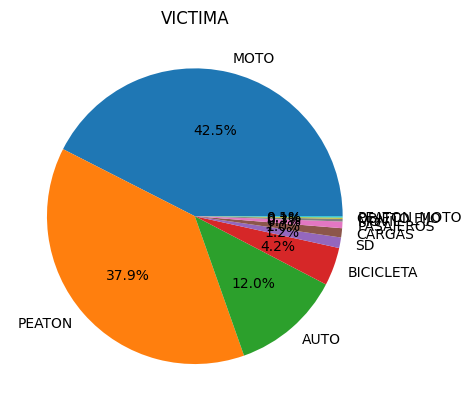

In [ ]:
showPie(data['VICTIMA'])

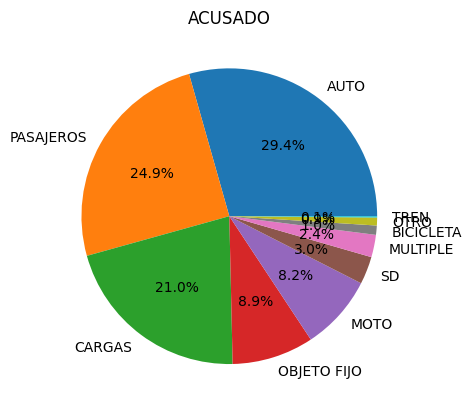

In [ ]:
showPie(data['ACUSADO'])

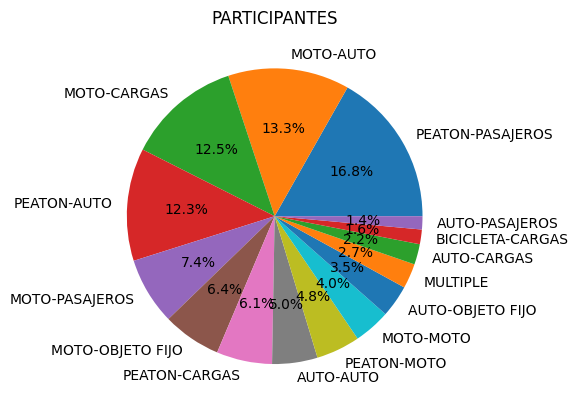

In [ ]:
showPie(data['PARTICIPANTES'])

In [ ]:
data.describe()

,N_VICTIMAS,FECHA,pos x,pos y,FECHA_HORA
count,694.000000,694,694.000000,694.000000,694
mean,1.030259,2018-09-16 01:52:02.766570496,-57.599448,-34.120790,2018-09-16 13:52:40.442363136
min,1.000000,2016-01-01 00:00:00,-58.529942,-34.705250,2016-01-01 04:00:00
25%,1.000000,2017-04-04 18:00:00,-58.475701,-34.643537,2017-04-05 13:41:15
50%,1.000000,2018-07-14 12:00:00,-58.443654,-34.622535,2018-07-14 18:47:00
75%,1.000000,2020-01-04 18:00:00,-58.399650,-34.595143,2020-01-05 11:40:00
max,3.000000,2021-12-30 00:00:00,0.000000,0.000000,2021-12-30 00:43:00
std,0.179644,NaN,6.969679,4.128761,NaN


In [ ]:
# data['ACUSADO'].corr(data['VICTIMA'])

48

In [ ]:


comunas['barrios'] = comunas.BARRIOS.apply(lambda x: x.split(' - '))

# pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas[['ID', 'COMUNAS']], left_on='comuna_id', right_on='ID')
comunas.set_index('COMUNAS', drop=True, inplace=True)
comunas.drop('ID', axis = 1, inplace=True, errors='ignore')
comunas.sort_index()

,OBJETO,BARRIOS,PERIMETRO,AREA,barrios
COMUNAS,,,,,
1,LIMITE COMUNAL,CONSTITUCION - MONTSERRAT - PUERTO MADERO - RE...,36102.201573,1.779457e+07,"[CONSTITUCION, MONTSERRAT, PUERTO MADERO, RETI..."
2,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
3,LIMITE COMUNAL,BALVANERA - SAN CRISTOBAL,10486.260809,6.385991e+06,"[BALVANERA, SAN CRISTOBAL]"
4,LIMITE COMUNAL,BARRACAS - BOCA - NUEVA POMPEYA - PARQUE PATRI...,35423.282799,2.168464e+07,"[BARRACAS, BOCA, NUEVA POMPEYA, PARQUE PATRICIOS]"
5,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
6,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
7,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
8,LIMITE COMUNAL,VILLA LUGANO - VILLA RIACHUELO - VILLA SOLDATI,20935.012513,2.221690e+07,"[VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI]"
9,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"


In [ ]:
pd.merge(pd.DataFrame(comunas.barrios.explode()).reset_index(names='comuna_id'), comunas, left_on='comuna_id', right_on='COMUNAS')

,comuna_id,barrios_x,OBJETO,BARRIOS,PERIMETRO,AREA,barrios_y
0,2,RECOLETA,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
1,5,ALMAGRO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
2,5,BOEDO,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
3,6,CABALLITO,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
4,7,FLORES,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
5,7,PARQUE CHACABUCO,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
6,9,LINIERS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
7,9,MATADEROS,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
8,9,PARQUE AVELLANEDA,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
9,10,FLORESTA,LIMITE COMUNAL,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"[FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS..."


In [ ]:
barrio_comuna = pd.DataFrame(comunas.barrios.explode())

In [ ]:
comunas

,OBJETO,BARRIOS,PERIMETRO,AREA,barrios
COMUNAS,,,,,
2,LIMITE COMUNAL,RECOLETA,21452.838648,6.317265e+06,[RECOLETA]
5,LIMITE COMUNAL,ALMAGRO - BOEDO,12323.432479,6.660603e+06,"[ALMAGRO, BOEDO]"
6,LIMITE COMUNAL,CABALLITO,10990.964471,6.851029e+06,[CABALLITO]
7,LIMITE COMUNAL,FLORES - PARQUE CHACABUCO,17972.257870,1.242290e+07,"[FLORES, PARQUE CHACABUCO]"
9,LIMITE COMUNAL,LINIERS - MATADEROS - PARQUE AVELLANEDA,21411.738344,1.650531e+07,"[LINIERS, MATADEROS, PARQUE AVELLANEDA]"
10,LIMITE COMUNAL,FLORESTA - MONTE CASTRO - VELEZ SARSFIELD - VE...,18332.037457,1.265656e+07,"[FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERS..."
11,LIMITE COMUNAL,VILLA DEL PARQUE - VILLA DEVOTO - VILLA GRAL....,19987.696155,1.412004e+07,"[VILLA DEL PARQUE, VILLA DEVOTO, VILLA GRAL. ..."
12,LIMITE COMUNAL,COGHLAN - SAAVEDRA - VILLA PUEYRREDON - VILLA ...,17232.189372,1.557093e+07,"[COGHLAN, SAAVEDRA, VILLA PUEYRREDON, VILLA UR..."
14,LIMITE COMUNAL,PALERMO,22126.531858,1.584587e+07,[PALERMO]


In [ ]:
# barrios.BARRIO.

In [ ]:
# import pandas as pd
# import researchpy as rp

# # Assuming df is your DataFrame containing the categorical variables
# # Let's say 'var1' and 'var2' are the columns representing the categorical variables

# data = data.reset_index()

# # Create a contingency table (cross-tabulation)
# contingency_table = pd.crosstab(data['ACUSADO'], data['VICTIMA'])

# # Calculate Cramér's V
# cramers_v_result = rp.crosstab(data['ACUSADO'], data['VICTIMA'], 
#                                 prop= 'cell', 
#                                 test= 'chi-square', 
#                                 expected_freqs= True, 
                                
#                                 correction= False)['results']

# cramers_v = cramers_v_result.loc[2, 'results']

# print("Cramér's V:", cramers_v)


In [ ]:
# %pip install ipywidgets

In [ ]:
pd.crosstab(data_hm['VICTIMA'], data_hm['ACUSADO'])


ACUSADO,AUTO,BICICLETA,CARGAS,MOTO,MULTIPLE,OBJETO FIJO,OTRO,PASAJEROS,SD,TREN
VICTIMA,,,,,,,,,,
AUTO,31,0,14,0,3,21,1,9,4,0
BICICLETA,8,0,10,0,1,0,1,8,0,1
CARGAS,1,0,4,0,0,1,0,1,0,0
MOTO,83,2,78,25,8,40,4,46,9,0
MOVIL,0,0,1,0,0,0,0,1,0,0
OBJETO FIJO,1,0,0,0,0,0,0,0,0,0
PASAJEROS,1,0,0,0,0,0,0,3,1,0
PEATON,77,5,38,30,5,0,0,105,3,0
PEATON_MOTO,0,0,0,1,0,0,0,0,0,0


In [ ]:
data_hm['ES_CRUCE'] = data_hm['Cruce'] != 'NA'

In [ ]:
data_hm['ES_CRUCE'].value_counts()

ES_CRUCE
True     525
False    169
Name: count, dtype: int64

In [ ]:
data_hm['Cruce'].fillna('NA', inplace=True)

In [ ]:
pd.crosstab(data_hm['PARTICIPANTES'], data_hm['ES_CRUCE']).sum()

ES_CRUCE
False    169
True     525
dtype: int64

In [ ]:
data_hm = data_hm.set_index(data_hm['ID']).drop(['ID','FECHA','HORA','LUGAR_DEL_HECHO'], axis=1)

In [ ]:
data_hm.columns = [c.lower().replace(' ','_') for c in data_hm.columns]

# plt.plot(data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum())

In [ ]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


In [ ]:
data_hm['comuna'][data_hm['comuna'].isnull()]

Series([], Name: comuna, dtype: object)

In [ ]:
data_hm['comuna'] = data_hm['comuna'].apply(lambda x: int(x))

In [ ]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,pos_x,pos_y,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,True
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,True
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,False
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,True
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,True
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,True
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,True


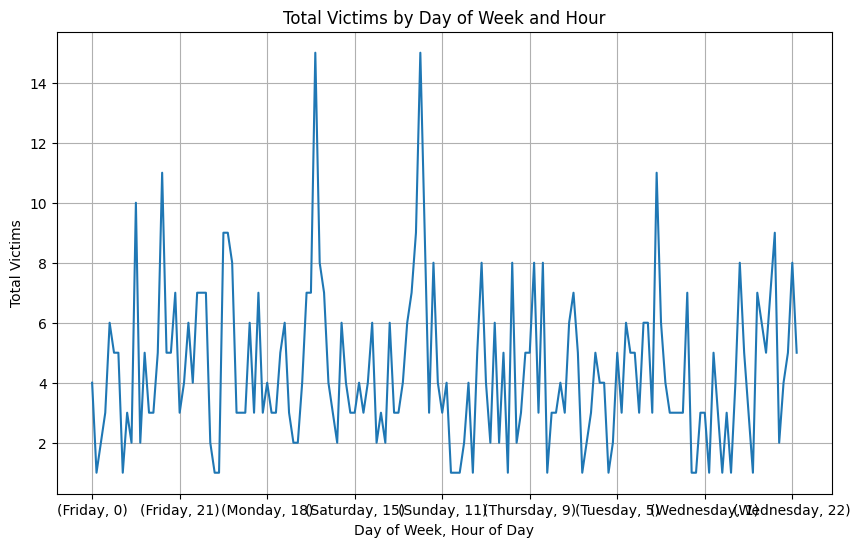

In [ ]:
import matplotlib.pyplot as plt

# Assuming data_hm['fecha_hora'] is already a datetime column in data_hm

# Group by day name and hour, then sum 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name(), data_hm['fecha_hora'].dt.hour])['n_victimas'].sum()

# Plot the result
grouped_data.plot(kind='line', figsize=(10, 6))
plt.xlabel('Day of Week, Hour of Day')
plt.ylabel('Total Victims')
plt.title('Total Victims by Day of Week and Hour')
plt.grid(True)
plt.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Hour_of_Day', y='n_victimas', color='Day_of_Week', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Day_of_Week', y='n_victimas', color='Hour_of_Day', 
             title='Total Number of Victims by Day of Week and Hour',
             labels={'Day_of_Week': 'Day of Week', 'n_victimas': 'Total Victims'},
             category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.day_name().rename('Day_of_Week'), 
                                 data_hm['fecha_hora'].dt.hour.rename('Hour_of_Day')])['n_victimas'].sum().reset_index()

# Iterate over unique days and create a separate bar plot for each day
for day in grouped_data['Day_of_Week'].unique():
    # Filter data for the current day
    day_data = grouped_data[grouped_data['Day_of_Week'] == day]
    
    # Create a bar plot for the current day
    fig = px.bar(day_data, x='Hour_of_Day', y='n_victimas', 
                 title=f'Total Number of Victims by Hour on {day}',
                 labels={'Hour_of_Day': 'Hour of Day', 'n_victimas': 'Total Victims'})
    
    # Show the plot
    fig.show()


In [ ]:
data_hm['es_cruce'] = data_hm['es_cruce'].map({False:'Calle', True:'Esquina'})

In [ ]:
import plotly.express as px

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a pie chart using Plotly Express
fig = px.pie(grouped_data, values='n_victimas', names='es_cruce', 
             title='Proportion of Victims by Crossing Status')

# Show the plot
fig.show()

In [ ]:
data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()['es_cruce'].map({False:"Calle", True:"Esquina"})

0    NaN
1    NaN
Name: es_cruce, dtype: object

In [ ]:
import pandas as pd

# Group data by 'es_cruce', summing 'n_victimas'
grouped_data = data_hm.groupby('es_cruce')['n_victimas'].sum().reset_index()

# Create a mapping dictionary
mapping = {False: "Calle", True: "Esquina"}

# Map boolean values to corresponding labels
grouped_data['es_cruce'] = grouped_data['es_cruce'].map(mapping)

# Show the result
print(grouped_data)

  es_cruce  n_victimas
0      NaN         175
1      NaN         540


In [ ]:
import plotly.express as px

# Group data by day name and hour, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                 data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Plotly Express
fig = px.bar(grouped_data, x='Año', y='n_victimas', color='Mes',
             title='Total Number of Victims by Day of Year and Month',)
            #  labels={'Año': 'Day of Week', 'n_victimas': 'Total Victims'},
            #  category_orders={'Day_of_Week': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})

# Show the plot
fig.show()

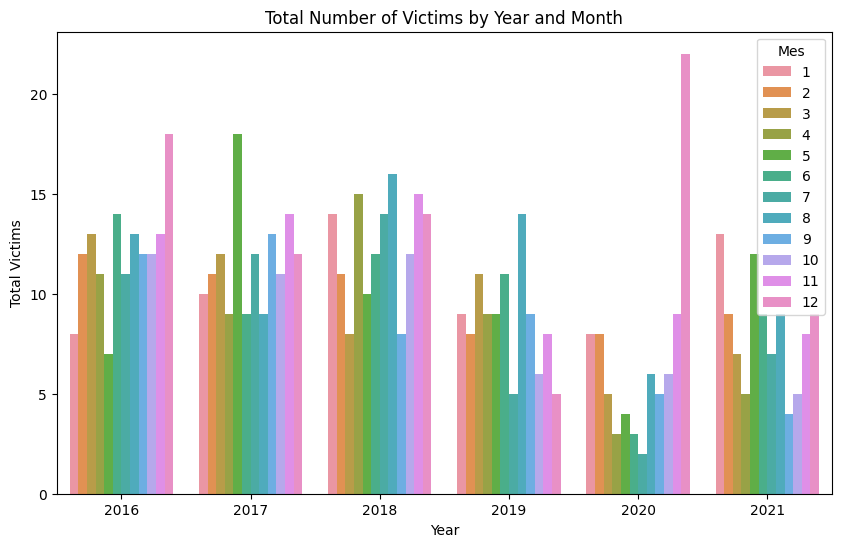

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group data by year and month, summing 'n_victimas'
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_data, x='Año', y='n_victimas', hue='Mes')

# Set plot title and labels
plt.title('Total Number of Victims by Year and Month')
plt.xlabel('Year')
plt.ylabel('Total Victims')

# Show the plot
plt.show()


In [ ]:
grouped_data = data_hm.groupby([data_hm['fecha_hora'].dt.year.rename('Año'), 
                                data_hm['fecha_hora'].dt.month.rename('Mes')])['n_victimas'].sum().reset_index()

grouped_data

,Año,Mes,n_victimas
0,2016,1,8
1,2016,2,12
2,2016,3,13
3,2016,4,11
4,2016,5,7
...,...,...,...
67,2021,8,9
68,2021,9,4
69,2021,10,5
70,2021,11,8


In [ ]:
data_hm.groupby(data_hm['fecha_hora'].dt.to_period('M'))['n_victimas'].sum()

fecha_hora
2016-01     8
2016-02    12
2016-03    13
2016-04    11
2016-05     7
           ..
2021-08     9
2021-09     4
2021-10     5
2021-11     8
2021-12     9
Freq: M, Name: n_victimas, Length: 72, dtype: int64

In [ ]:
data_hm['fecha_hora'].dt.to_period('M')

ID
2016-0001    2016-01
2016-0002    2016-01
2016-0003    2016-01
2016-0004    2016-01
2016-0005    2016-01
              ...   
2021-0093    2021-12
2021-0094    2021-12
2021-0095    2021-12
2021-0096    2021-12
2021-0097    2021-11
Name: fecha_hora, Length: 694, dtype: period[M]

In [ ]:
import plotly.express as px

# Group data by month, summing 'n_victimas'
grouped_data = data_hm.groupby(data_hm['fecha_hora'].dt.to_period('Y'))['n_victimas'].sum().reset_index()

# Convert Period objects to strings
grouped_data['fecha_hora'] = grouped_data['fecha_hora'].astype(str)

# Create a line plot using Plotly Express
fig = px.line(grouped_data, x='fecha_hora', y='n_victimas', 
              title='Total Number of Victims Over Time',
              labels={'fecha_hora': 'Month', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()


In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx')

In [ ]:
data_hm.pos_y.mean()

-34.12078961688012

In [ ]:
import folium
from branca.colormap import LinearColormap

# Assuming data contains latitude, longitude, and the value you want to use for color
# Replace 'value_column' with the actual name of the column in your DataFrame
value_column = 'comuna'

data_hm[value_column] = pd.to_numeric(data_hm[value_column], errors='coerce')

data_hm = data_hm.dropna()
data_hm = data_hm.rename({'pos_x': 'lon',  'pos_y': 'lat'}, axis=1)

# Define the minimum and maximum values for the color scale
min_value = data_hm[value_column].astype(float).min()
max_value = data_hm[value_column].astype(float).max()

# Create a color gradient
colormap = LinearColormap(['blue', 'yellow', 'red'], vmin=min_value, vmax=max_value)

# Create a Folium Map
map = folium.Map()

# Iterate over DataFrame rows
for i, row in data_hm.iterrows():
    # Get latitude, longitude, and value
    lat = row['lat']
    lon = row['lon']
    value = row[value_column]
    
    # Get marker color based on the value
    color = colormap(value)
    
    # Create marker with the specified color
    folium.Marker(location=(lat, lon), icon=folium.Icon(color=color)).add_to(map)

# Display the map
# map

In [ ]:
import csv

data_hm.to_csv('data/generated/data_hm.csv', sep=';', quoting=csv.QUOTE_NONNUMERIC, encoding='utf-8')

In [ ]:
data = pd.read_csv('data/generated/data_hm.csv', sep=';', encoding='utf-8')

In [ ]:
data.iloc[136]

ID                                         2016-0172
n_victimas                                         1
tipo_de_calle                                AVENIDA
calle                             GARAY, JUAN DE AV.
altura                                           ESQ
cruce                                         CASTRO
dirección_normalizada    GARAY, JUAN DE AV. y CASTRO
comuna                                             5
lon                                       -58.419189
lat                                       -34.631743
participantes                            MOTO-CARGAS
victima                                         MOTO
acusado                                       CARGAS
geo_info                                        True
fecha_hora                       2016-12-26 08:00:00
es_cruce                                     Esquina
Name: 136, dtype: object

In [ ]:
# data_hm.to_excel('data/generated/data_hm.xlsx', engine='openpyxl')

In [ ]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 2016-0001 to 2021-0097
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   n_victimas             694 non-null    int64         
 1   tipo_de_calle          694 non-null    object        
 2   calle                  694 non-null    object        
 3   altura                 694 non-null    object        
 4   cruce                  694 non-null    object        
 5   dirección_normalizada  694 non-null    object        
 6   comuna                 694 non-null    int64         
 7   lon                    694 non-null    float64       
 8   lat                    694 non-null    float64       
 9   participantes          694 non-null    object        
 10  victima                694 non-null    object        
 11  acusado                694 non-null    object        
 12  geo_info               694 non-null    bool          
 

In [ ]:
data_dias = data_hm.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias})

In [ ]:
data_dias = data.groupby(pd.to_datetime(data['fecha_hora']).dt.day_of_week)['n_victimas'].count().reset_index()

In [ ]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

,fecha_hora,n_victimas
0,0,103
1,1,96
2,2,97
3,3,94
4,4,95
5,5,102
6,6,97


In [ ]:
data_dias = data.groupby(data['fecha_hora'].dt.day_of_week)['n_victimas'].count().reset_index()

# st.dataframe(data_dias)

# grouped_data = data.groupby(data['fecha_hora'].dt.dayofweek)['n_victimas'].count().reset_index()

nombre_dias = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

data_dias['dia_semana'] = data_dias['fecha_hora'].map(lambda x: nombre_dias[x])

data_dias.drop(columns=['fecha_hora'], inplace=True)
data_dias.columns = ['Dia Semana', 'Accidentes']

# Sort the data in descending order
data_dias = data_dias.sort_values(by='Dia Semana', ascending=True)

# Create a stacked bar plot using Plotly Express
fig = px.bar(data_dias, x='Accidentes', y='Dia Semana', 
             title='Accidentes por Día Semana',
             color='Dia Semana',
             color_continuous_scale=["#A1FFA1", "yellow", "red"],
            #  labels={'Accidentes': 'Accidentes', 'Dia Semana':'Dia Semana'},
             category_orders={'Dia Semana': nombre_dias},
             orientation='h')

fig.show()

In [ ]:
data.query('fecha_hora.dt.month == 12 and fecha_hora.dt.year == 2020').n_victimas.sum()

22

In [ ]:
data = pd.read_excel('data/generated/data_hm.xlsx', engine='openpyxl')

datos = data.groupby([data['fecha_hora'].dt.year, data['fecha_hora'].dt.month//6 + 1, data['fecha_hora'].dt.month])['n_victimas'].sum()

datos = datos.rename_axis(['Year', 'Semester', 'Month'])

datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Month' as a string
datos['date'] = datos['Year'].astype(str) + '-' + datos['Month'].astype(str).str.zfill(2)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Month and Year',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'},
             color='n_victimas')

# Show the plot
fig.show()

# datos.head(50)

In [ ]:
datos = data.groupby([data['fecha_hora'].dt.year, (data['fecha_hora'].dt.month - 1) // 6 + 1])['n_victimas'].sum()

# Rename the MultiIndex
datos = datos.rename_axis(['Year', 'Semester'])

# Reset the index
datos = datos.reset_index()

# Create a new column 'date' combining 'Year' and 'Semester' as a string
datos['date'] = datos['Year'].astype(str) + '-Semester ' + datos['Semester'].astype(str)

# Create a bar plot using Plotly Express
fig = px.bar(datos, x='date', y='n_victimas',
             title='Total Victims by Year and Semester',
             color='n_victimas',
             labels={'date': 'Date', 'n_victimas': 'Total Victims'})

# Show the plot
fig.show()

In [ ]:
data_hm

,n_victimas,tipo_de_calle,calle,altura,cruce,dirección_normalizada,comuna,lon,lat,participantes,victima,acusado,geo_info,fecha_hora,es_cruce
ID,,,,,,,,,,,,,,,
2016-0001,1,AVENIDA,PIEDRA BUENA AV.,ESQ,"FERNANDEZ DE LA CRUZ, F., GRAL. AV.","PIEDRA BUENA AV. y FERNANDEZ DE LA CRUZ, F., G...",8,-58.475340,-34.687570,MOTO-AUTO,MOTO,AUTO,True,2016-01-01 04:00:00,Esquina
2016-0002,1,GRAL PAZ,"PAZ, GRAL. AV.",ESQ,DE LOS CORRALES AV.,"PAZ, GRAL. AV. y DE LOS CORRALES AV.",9,-58.508775,-34.669777,AUTO-PASAJEROS,AUTO,PASAJEROS,True,2016-01-02 01:15:00,Esquina
2016-0003,1,AVENIDA,ENTRE RIOS AV.,2034,NA,ENTRE RIOS AV. 2034,1,-58.390403,-34.631894,MOTO-AUTO,MOTO,AUTO,True,2016-01-03 07:00:00,Calle
2016-0004,1,AVENIDA,LARRAZABAL AV.,ESQ,"VILLEGAS, CONRADO, GRAL.","LARRAZABAL AV. y VILLEGAS, CONRADO, GRAL.",8,-58.465039,-34.680930,MOTO-SD,MOTO,SD,True,2016-01-10 00:00:00,Esquina
2016-0005,1,AVENIDA,SAN JUAN AV.,ESQ,"SAENZ PE?A, LUIS, PRES.","SAN JUAN AV. y SAENZ PEÃ‘A, LUIS, PRES.",1,-58.387183,-34.622466,MOTO-PASAJEROS,MOTO,PASAJEROS,True,2016-01-21 05:20:00,Esquina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-0093,1,AVENIDA,RIESTRA AV.,ESQ,MOM,RIESTRA AV. y MOM,7,-58.433538,-34.645616,MOTO-AUTO,MOTO,AUTO,True,2021-12-13 17:10:00,Esquina
2021-0094,1,AUTOPISTA,"DELLEPIANE, LUIS, TTE. GRAL.",ESQ,LACARRA AV.,"DELLEPIANE, LUIS, TTE. GRAL. y LACARRA AV.",9,-58.467398,-34.651178,MOTO-AUTO,MOTO,AUTO,True,2021-12-20 01:10:00,Esquina
2021-0095,1,AVENIDA,GAONA AV.,ESQ,TERRADA,GAONA AV. y TERRADA,11,-58.472934,-34.619847,MOTO-CARGAS,MOTO,CARGAS,True,2021-12-30 00:43:00,Esquina


# EDA

In [ ]:
showPiePx(data_hm.n_victimas)

In [ ]:

# sns.catplot(x="tipo_de_calle", data = data_hm['tipo_de_calle', 'n_victimas'].groupby("tipo_de_calle").sum(), kind='box')

In [ ]:
showPiePx(data_hm.tipo_de_calle)


In [ ]:
data_hm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 694 entries, 2016-0001 to 2021-0097
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   n_victimas             694 non-null    int64         
 1   tipo_de_calle          694 non-null    object        
 2   calle                  694 non-null    object        
 3   altura                 694 non-null    object        
 4   cruce                  694 non-null    object        
 5   dirección_normalizada  694 non-null    object        
 6   comuna                 694 non-null    int64         
 7   lon                    694 non-null    float64       
 8   lat                    694 non-null    float64       
 9   participantes          694 non-null    object        
 10  victima                694 non-null    object        
 11  acusado                694 non-null    object        
 12  geo_info               694 non-null    bool          
 

In [ ]:
showPiePx(data_hm.es_cruce)

In [ ]:
showPiePx(data_hm.comuna)

In [ ]:
showPiePx(data_hm.participantes)

In [ ]:
showPiePx(data_hm.victima)

In [ ]:
showPiePx(data_hm.acusado)

In [ ]:
# pd.concat(data_hm.query("tipo_de_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'], data_hm.query("tipo_de_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'], axis=1)

In [ ]:
import pandas as pd

autopista_counts = data_hm.query("tipo_de_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas']
avenida_counts = data_hm.query("tipo_de_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas']

concatenated_counts = pd.concat([autopista_counts, avenida_counts], axis=1)


In [ ]:
import pandas as pd

# Calculate total occurrences for each type of street
total_autopista = data_hm.query("tipo_de_calle == 'AUTOPISTA'")['n_victimas'].count()
total_avenida = data_hm.query("tipo_de_calle == 'AVENIDA'")['n_victimas'].count()

# Calculate frequencies
autopista_counts = data_hm.query("tipo_de_calle == 'AUTOPISTA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'] / total_autopista
autopista_counts.name = 'AUTOPISTA Frequency'

avenida_counts = data_hm.query("tipo_de_calle == 'AVENIDA'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'] / total_avenida
avenida_counts.name = 'AVENIDA Frequency'

# Concatenate into a DataFrame
concatenated_frequencies = pd.concat([autopista_counts, avenida_counts], axis=1)


In [ ]:
data_hm.tipo_de_calle.value_counts()

tipo_de_calle
AVENIDA      429
CALLE        135
GRAL PAZ      65
AUTOPISTA     65
Name: count, dtype: int64

In [ ]:
pd.DataFrame([data_hm.query(f"tipo_de_calle == '{st}'").groupby(data_hm['fecha_hora'].dt.day_of_week).count()['n_victimas'].rename(f"{st}") for st in data_hm.tipo_de_calle.unique()]).T

,AVENIDA,GRAL PAZ,CALLE,AUTOPISTA
fecha_hora,,,,
0,67,11,15,13
1,58,6,25,9
2,62,9,18,9
3,62,5,18,9
4,65,6,20,5
5,59,12,23,9
6,56,16,16,11


In [ ]:
((data_hm.fecha_hora.dt.month-1) // 6).value_counts()

fecha_hora
1    357
0    337
Name: count, dtype: int64